In [1]:
# CNTK 2.1 installálása Anaconda 3 alá itt található:
# https://docs.microsoft.com/en-us/cognitive-toolkit/setup-windows-python?tabs=cntkpy21
import IPython.display as D
from scipy.misc import imsave
import matplotlib.pyplot as plt
import numpy as np
import os
import cntk as C

In [2]:
# ha nincs megfelelő videókártya, vagy CUDA 8 támogatás, akkor csak CPU fog menni.
# Ekkor a batch noramlizációs változatok nem működnek
isGPUEnabled = True
if isGPUEnabled == True:
    C.device.try_set_default_device(C.device.gpu(0))
else:
    C.device.try_set_default_device(C.device.cpu())

In [3]:
# ahol a notebookhoz képest az adatbázis van, azt kell itt referálni
data_path = os.path.join('..','Examples','Image', 'Datasets','src')
# model dimenziói
image_height = 40
image_width  = 40
num_channels = 3
num_classes  = 2
pred_vgg = C.load_model("src.model")

In [4]:
# kép ellenőrzés

from PIL import Image as Image2

def eval_single_image(loaded_model, image_path):
    # load and format image (resize, RGB -> BGR, CHW -> HWC)
    try:
        img = Image2.open(image_path).convert("RGBA")
        
        if image_path.endswith("png"):
            temp = Image2.new("RGBA", img.size, (255, 255, 255))
            temp.paste(img, img)
            img = temp
        resized = img.crop((img.width/2-20, img.height/2-20, img.width/2+20, img.height/2+20))
        bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
        hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

        # compute model output
        arguments = {loaded_model.arguments[0]: [hwc_format]}
        output = loaded_model.eval(arguments)

        # return softmax probabilities
        sm = C.softmax(output[0])
        return sm.eval()
    except FileNotFoundError:
        print("Could not open (skipping file): ", image_path)
        return ['None']
        
# Evaluates an image set using the provided model
def eval_test_images(test_map_file, loaded_model):
    num_images = sum(1 for line in open(test_map_file))
        
    print("Evaluating model output node '{0}' for {1} images.".format('prediction', num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise')
    with open(test_map_file, "r") as input_file:
        for line in input_file:
            tokens = line.rstrip().split('\t')
            img_file = tokens[0]
            probs = eval_single_image(loaded_model, img_file)
            
            if probs[0]=='None':
                print("Eval not possible: ", img_file)
                continue

            pred_count += 1
            true_label = int(tokens[1])
            predicted_label = np.argmax(probs)
            if predicted_label == true_label:
                correct_count += 1

            if pred_count % 1000 == 0:
                print("Processed {0} samples ({1:.2%} correct)".format(pred_count, 
                                                                       (float(correct_count) / pred_count)))
            if pred_count >= num_images:
                break
    print ("{0} of {1} prediction were correct".format(correct_count, pred_count))
    return correct_count, pred_count, (float(correct_count) / pred_count)

In [5]:
eval_test_images(os.path.join(data_path, 'test_map.txt'), pred_vgg)

Evaluating model output node 'prediction' for 53 images.
48 of 53 prediction were correct


(48, 53, 0.9056603773584906)

In [6]:
# Clone the desired layers with fixed weights
feature_node = C.logging.find_by_name(pred_vgg, 'features')
last_node = C.logging.find_by_name(pred_vgg, 'D')
cloned_layers = C.combine([last_node.owner]).clone(C.CloneMethod.freeze, {feature_node: C.placeholder(name='features')})

image_input1 = C.input_variable((3,480,640))
cloned_out1 = cloned_layers(C.element_times(1/256.0, image_input1, name="features"))
z1 = C.layers.Dense(2, activation=None, name="out") (cloned_out1)

#image_input2 = C.input_variable((3,2048,2048))
#cloned_out2 = cloned_layers(C.element_times(1/256.0, image_input2, name="features"))
#z2 = C.layers.Dense(2, activation=None, name="out") (cloned_out2)

x1= C.logging.find_by_name(pred_vgg, 'Output').W.value[0][0][0][0]
y1= C.logging.find_by_name(pred_vgg, 'Output').W.value[1][0][0][0]
x2= C.logging.find_by_name(pred_vgg, 'Output').W.value[0][0][0][1]
y2= C.logging.find_by_name(pred_vgg, 'Output').W.value[1][0][0][1]

In [7]:
img = Image2.open("001.png").convert("RGBA")
temp = Image2.new("RGBA", img.size, (255, 255, 255))
temp.paste(img, img)
img = temp
bgr_image = np.asarray(img, dtype=np.float32)[..., [2, 1, 0]]
hwc_format1 = np.ascontiguousarray(np.rollaxis(bgr_image, 2))
arguments1 = {cloned_out1.arguments[0]: [hwc_format1]}
img = Image2.open("002.png").convert("RGBA")
temp = Image2.new("RGBA", img.size, (255, 255, 255))
temp.paste(img, img)
img = temp
bgr_image = np.asarray(img, dtype=np.float32)[..., [2, 1, 0]]
hwc_format2 = np.ascontiguousarray(np.rollaxis(bgr_image, 2))
arguments2 = {cloned_out1.arguments[0]: [hwc_format2]}
img = Image2.open("003.png").convert("RGBA")
temp = Image2.new("RGBA", img.size, (255, 255, 255))
temp.paste(img, img)
img = temp
bgr_image = np.asarray(img, dtype=np.float32)[..., [2, 1, 0]]
hwc_format3 = np.ascontiguousarray(np.rollaxis(bgr_image, 2))
arguments3 = {cloned_out1.arguments[0]: [hwc_format3]}

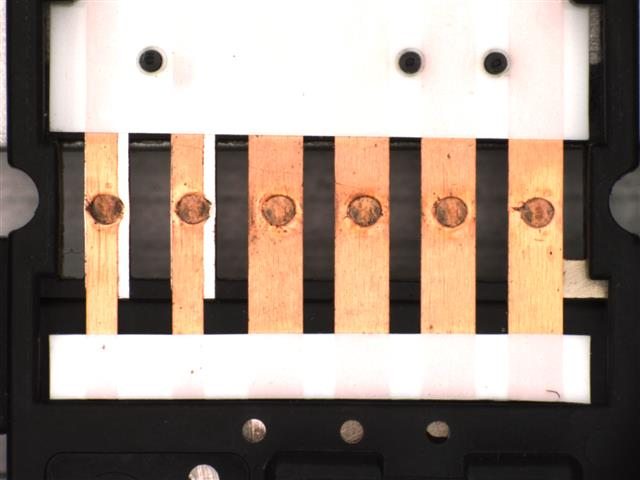

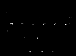

In [8]:
output = cloned_out1.eval(arguments1)
CXY=np.zeros([56, 76])
for i in range(56):
    for j in range(76):
        CXY[i,j]=max((x1-x2)*output[0,0,i,j]+(y1-y2)*output[0,1,i,j]-0.03,0)
imsave("image.png", CXY)
D.display(D.Image('001.png',width='640', height='480'))
D.display(D.Image('image.png',width='640', height='480'))

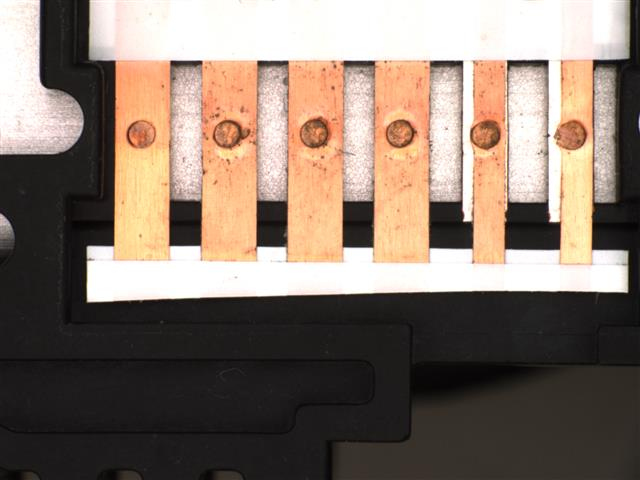

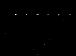

In [9]:
output = cloned_out1.eval(arguments2)
CXY=np.zeros([56, 76])
for i in range(56):
    for j in range(76):
        CXY[i,j]=max((x1-x2)*output[0,0,i,j]+(y1-y2)*output[0,1,i,j]-0.03,0)
imsave("image.png", CXY)
D.display(D.Image('002.png',width='640', height='480'))
D.display(D.Image('image.png',width='640', height='480'))

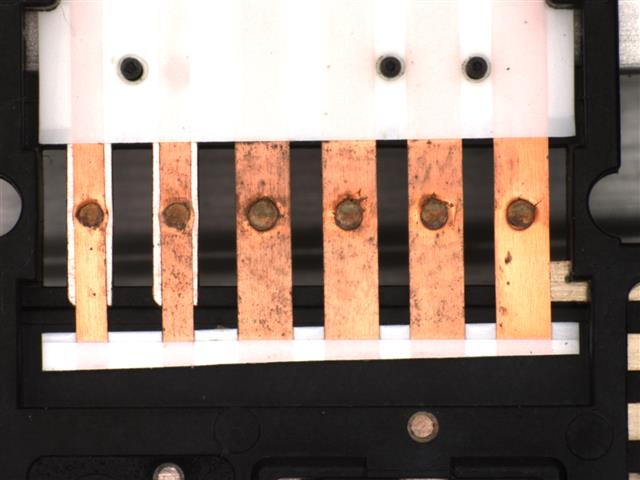

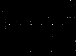

In [10]:
output = cloned_out1.eval(arguments3)
CXY=np.zeros([56, 76])
for i in range(56):
    for j in range(76):
        CXY[i,j]=max((x1-x2)*output[0,0,i,j]+(y1-y2)*output[0,1,i,j]-0.03,0)
imsave("image.png", CXY)
D.display(D.Image('003.png',width='640', height='480'))
D.display(D.Image('image.png',width='640', height='480'))